# Avalanche prediction by machine learning
Author: Benjamin Bissig, Bahnhofstrasse 13, 6460 Altdorf, bebissig@gmail.com

## 1. Abstract:
__Approach overview__: 

1. Collect sets of
    - positive samples (avalanche accidents)
    - negatives samples (no avalanche accidents)
2. Numerically analyze the terrain and collect information about snow conditions for each sample
3. Employ classification algorithm to estimate probability for an avalanche release for a given sample 

__Core restrictions and assumptions__: 
- As time series of SLF station measurement are not openly available, only daily SLF bulletins and terrain attributes were be used as predictors. (The approach however is extendable if such data become available. E.g. information of average wind direction / percipitation during preceeding days in combination with terrain attributes could be neatlessly incorperated.)

- Focus on self-induced (causal) avalanche accidents due winter sport activities. Hence, in a coarse approximation only accidents through November until March and without "Sachschäden" were considered.

__Long term target__: 
- Render low-avalanche-likelihood tracks with high confidence on given day through given terrain. 
- Provide accurate information for supporting decisions of well informed mountain-enthusiasts. 
- Ever increasing accuracy when more information (samples) are fed by users in the field
- Possibly make such information available for regions without expert danger assessement but with an adequate amount of meteorological data

__Literature__: This approach discriminates from the work of Mr. Günter Schmudlach @ Skiturenguru.ch and other "danger indicator" based approaches as describe e.g. here http://arc.lib.montana.edu/snow-science/objects/ISSW2018_O15.1.pdf. In contrast to an expert model that predicts the danger level based on a terrain-indicator and dailiy bulletins, here no prior expert model is introduced.


### Data:
- Collected a set of ~10'000 skitour reports (date, peak, ...) through winters 15/16 and 16/17


- Collected a set of ~1000 skitour gps tracks


- Collected maps of daily avalanche bulletin from SLF archiv for winters 12/13, 13,14, 14/15, 15/16 and 16/17:
    - https://www.slf.ch/de/lawinenbulletin-und-schneesituation/archiv.html
    
    
- Acquired list of all SLF msm. stations (w/coordinates):
    - kindly provided by Michel Bovey @ SLF on 20. March 2018, email correspondence
    - extracted time series of SLF avalanche level at station-positions for these winters


- Collected avalanche accidents (dates, coords, ...) from PDF SLFWinterbericht for these winters
    - https://www.slf.ch/de/lawinenbulletin-und-schneesituation/wochen-und-winterberichte/201213.html
    - https://www.slf.ch/de/lawinenbulletin-und-schneesituation/wochen-und-winterberichte/201314.html
    - https://www.slf.ch/de/lawinenbulletin-und-schneesituation/wochen-und-winterberichte/201415.html
    - https://www.slf.ch/de/lawinenbulletin-und-schneesituation/wochen-und-winterberichte/201516.html
    - https://www.slf.ch/de/lawinenbulletin-und-schneesituation/wochen-und-winterberichte/201617.html
    
    
- Digital elevation model from Copernicus* satelite survey, EU-DEM v1.1 for analysis of terrain
    - https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1?tab=metadata 
    - 25m resolution, +-7m RMSE 

### Procedure:
- For each track (an exemplaric visualization is shown in the left hand side image below):
    - find steepest point within 200m from peak
    - find steeptest point within 200m below peak to 1000 m below peak
    - select 3 additional random points on route (more statistics)
    - (Implementation not shown in this notebook)

- For each of the selected __track points__ and for each avalanche __accident coordinate__ (an exemplaric visualization is shown in the right hand side image below) make an estimate of:
    - __altitude__
    - __slope__
    - __exposition__ (N:0 > E:pi/2 > -- > N:2pi)
    - "vertical convexity" of the terrain, __curv_v__
    - "horizontal convexity" of the terrain, __curv_h__
    - angle dependent distance to next ridge
        - for the __models below, only the distance to the nearest ridge min_r was used as predictor__ (if e.g. knowledge about the average wind direction in the preceeding days was available, the distance to the closest ridge in direction "agains" wind could be used)
    - (Implementations not shown in this notebook, but some references for algorithms that were used are given below)
         
- All data is stored in a relationonal postgreSQL database       
- Query database to obtain (for each accident) a combined table of the bulletin (e.g. an average for stations within 15km) and terrain attributes. These are used used as predictors (also called __features__) for the occurence of an accident:


| date       | avg_bulletin | altitude | exposition | min_r  | slope | curv_h | curv_v | accident |
|------------|--------------|----------|------------|--------|-------|--------|--------|----------|
| 2015-10-04 | 2            | 3600.91  | 0.07       | 194.73 | 31.98 | 0.00   | -0.07  | 1        |
| 2015-10-24 | 2            | 3755.26  | 1.70       | 48.78  | 13.95 | 0.33   | 0.14   | 1        |

    
- Query database to obtain similar table for points on the reported gpx tracks:
    
| tour_date  | tour_pk_name   | avg_bulletin | altitude | expo | min_r | slope | curv_h | curv_v | accident |
|------------|----------------|--------------|---------------|-----------|------------|------------|-------------|-------------|----------|
| 21.01.2016 | peakname1      | 2            | 1846.44       | 0.41      | 218.78     | 26.35      | 0.04        | -0.09       | 0        |
| 12.03.2016 | peakname2 | 2            | 2113.04       | 2.32      | 35.55      | 13.46      | -0.03       | -0.07       | 0        |    

- Cast/combine to suitable dataframe and split into training and test sets 
- __Train machine the learning algorithms using the specified features and evaluate on test set that was not involved in training.__
- Define and analyze suitable __scores__ for the predictions made by the learning algorithm

##  2. Methods/Computing/Algorithms:
- All implementation in python 3.6.6 (numpy, pandas, scipy, matplotlib) in anaconda suite: https://www.anaconda.com/distribution/
- Underlying data-analysis, scripting in spider IDE: https://www.spyder-ide.org/
- Final compilation and learning in a Jupyter notebook
- Machine learning algorithms from scikit-learn: https://scikit-learn.org/stable/
- Basic literature on statistical models used: "Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006"
- Relational database: https://www.postgresql.org/
- Python -> postgresql connector: https://pypi.org/project/psycopg2/
- Richdem library for terrain analysis: https://pypi.org/project/richdem/ (exposition, convexity)
- Mountain ridge determination algorithm described here: Koka et al., Procedia Computer Science 4, (2011), 216–221)
- Closest ridge determination described here (homebuilt): https://gis.stackexchange.com/questions/319217/distance-to-a-ridge-as-function-of-angle-python

*This work is not officially endorsed by the European Union. Free use under: (EU) No 1159/2013 of 12 July 2013


<table><tr><td><img src='track_example.png'></td><td><img src='terrain_example.png'></td></tr></table>
Examples of gps-track (left), and terrain analysis (right).

- Right click --> show in other tab for larger view

### Import librariers for analysis

In [5]:
import pandas as pd
import numpy as np
import psycopg2
import sys
import matplotlib.pyplot as plt
if r'C:\Users\Lenovo\Dropbox\Code\avalanche\postgresql' not in sys.path:
    sys.path.append(r'C:\Users\Lenovo\Dropbox\Code\avalanche\postgresql')
if r'C:\Users\Lenovo\Dropbox\Code\machine_learning' not in sys.path:
    sys.path.append(r'C:\Users\Lenovo\Dropbox\Code\machine_learning')
from lib_jupyter import pretty_print
from postgresql.config import config
import seaborn as sns


# 3. Query tours: tour_attributes/nearby_bulletin/track_point_terrain_attributes

__Specifications__:
- Select only skitours through Nov - March 
    - Assumption: the current approach targets causally induced avalanches, predominantely occuring during the winter months
- Select skitours with unique associated gps track (~ tour_peak_name = gps_peak_name) only
    - this in order to avoid a messy assignement btw. a specific ascent (gps track) and a tour-entry (numerous peaks allow multiple ascents)
    - Assumption: the ascent was close to that track, notably source of gps track and tour-report may differ
- Only select skitours for which on the given day, the SLF bulletin at stations within 15 km was specified (query returns the avarage bulletin at stations within this range)
- For each tour, get the steepest point in the top 200m and the 200m to 1000m below peak corridor. Additionally query one random position on the track.

--> __the negative (no-avalanche) sample ground truth__

In [6]:
conn = None
sql =   '''
            /* a selection of peaks with only one track (PeaksWithUniqueTracks)*/
             WITH pwut AS(
                SELECT  
                    tracks.pk_name,
                    tracks.id
                FROM gpx_tracks AS tracks
                WHERE tracks.pk_name NOT IN(
                    SELECT pk_name 
                    FROM gpx_tracks
                    GROUP BY pk_name
                        HAVING
                            COUNT(pk_name)>1)
                ORDER BY
                    tracks.pk_name),
                    
            all_tours AS(
                SELECT
                    tours.id,
                    tours.tour_date,
                    tours.pk_name,
                    tours.eastinglv03,
                    tours.northinglv03,
                    tours.rt_type,
                    get_distance(tours.eastinglv03,tours.northinglv03) AS f
                FROM tours)
            

            SELECT 
                all_tours.id,
                all_tours.tour_date,
                all_tours.pk_name,
                all_tours.eastinglv03,
                all_tours.northinglv03,
                pwut.pk_name,
                pwut.id,
                tr_attrib.altitude,
                tr_attrib.exposition,
                tr_attrib.min_r,
                tr_attrib.slope,
                tr_attrib.curv_h,
                tr_attrib.curv_v,
                tr_attrib.coord_type,
                AVG(NULLIF(bulletin, 'NaN'))

            FROM all_tours
            
            INNER JOIN pwut ON all_tours.pk_name = pwut.pk_name
            INNER JOIN track_coord_attributes_v0_1 AS tr_attrib ON tr_attrib.id_track = pwut.id 
            INNER JOIN stations_bulletin ON (stations_bulletin.date,stations_bulletin.station_id)= (tour_date,(f).stat_id_out)
            /* last inner join rejects nan-averaged bulletins*/
            WHERE 
                    all_tours.rt_type = 'Skitour / Snowboardtour'
                AND
                    (EXTRACT(MONTH FROM all_tours.tour_date) > 10
                    OR
                    EXTRACT(MONTH FROM all_tours.tour_date) < 4)
                AND
                    (tr_attrib.coord_type = 'ms_c0' 
                    OR
                     tr_attrib.coord_type ='ms_c1'
                    OR
                     tr_attrib.coord_type= 'onrt_rand0')
                AND 
                    (f).dist < 15000
                    
            GROUP BY 
                all_tours.id,
                all_tours.tour_date,
                all_tours.pk_name,
                all_tours.eastinglv03,
                all_tours.northinglv03,
                pwut.pk_name,
                pwut.id,
                tr_attrib.altitude,
                tr_attrib.exposition,
                tr_attrib.min_r,
                tr_attrib.slope,
                tr_attrib.curv_h,
                tr_attrib.curv_v,
                tr_attrib.coord_type
                
            ORDER BY
                all_tours.tour_date ASC 
        '''
    
try:
    params = config(filename='postgresql/database.ini',section='avalanche_terrains')
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    cur.execute(sql)
    results=cur.fetchall()
    cur.close()
#     conn.commit()
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
finally:
    if conn is not None:
        conn.close()  
                
        
columns= [  'tour_id', 'tour_date', 'tour_pk_name','tour_eastinglv03','tour_northinglv03',\
            'track_pk_name', 'track_id','trpt_altitude', 'trpt_expo', 'trpt_min_r',\
            'trpt_slope','trpt_curv_h','trpt_curv_v','trpt_coord_type','bulletin']
df_skitours_query=pd.DataFrame(results,columns=columns)
print('Import shape: {}'.format(df_skitours_query.shape))
# pretty_print(df_skitours_reduced.head())
# pretty_print(df_skitours_reduced.tail())


Import shape: (2871, 15)


### - manually remove duplicate peaks
- delete peaks (only two) for which supposed gpx track is far away from peak_coordinates (i.e. same peak name exists multiple times)

In [7]:
df_skitours_manudel = df_skitours_query[df_skitours_query.tour_pk_name != 'Rothorn']
df_skitours_manudel = df_skitours_manudel[df_skitours_manudel.tour_pk_name != 'Piz Cotschen']

# pretty_print(df_skitours_reduced_manudel.groupby(['tour_pk_name','tour_eastinglv03']).head(1).groupby(['tour_pk_name']).filter(lambda g: len(g)>1))
# the head(1) removes multiple dates

# (PARTLY!) DELETE
# Rothorn: None of Rothorns is close to Rothorn_gpx track window
# Piz Cotschen: The Piz Cotschen @ east 822800.0 is not near piz cotschen map
# --> better: only partly delete Cotschen but selective after easting did not work

# LEAVE:
# Le Tarent
# Pesciora
# Vadret
# Aig. des Angroniettes

# unique counts after delte:
# df_skitours_reduced_manudel.nunique()
print('Shape routes dataset: {}'.format(df_skitours_manudel.shape))


Shape routes dataset: (2850, 15)


### - select only one tour per day and peak

In [8]:
df_skitours_manudel = df_skitours_manudel.groupby(['tour_date','tour_pk_name','trpt_coord_type']).head(1)

### - some final statistics for tour import

In [9]:
print(df_skitours_manudel.nunique())
print('Shape routes dataset: {}'.format(df_skitours_manudel.shape))

tour_id              913
tour_date            204
tour_pk_name         236
tour_eastinglv03     238
tour_northinglv03    239
track_pk_name        236
track_id             236
trpt_altitude        684
trpt_expo            409
trpt_min_r           444
trpt_slope           620
trpt_curv_h          145
trpt_curv_v          139
trpt_coord_type        3
bulletin              42
dtype: int64
Shape routes dataset: (2715, 15)


- 913 skitours meeting the specifications
- on 204 distinct days
- on 236 distinct peaks
- on 238 distinct peak coordinates
    --> manually checked, that the coordinates are close to intended peak
- 3 points per route were queried (ms_c0, ms_c1, onrt_rand0)
    - __roughly 3*913 ~ 2700 terrain/bulletin-vectors that did not release an avalanche (negative samples)__

### - casting into form for learner
- dropping about 100 columns containing NaN values (?? check location/origin of those NaNs)
- adding an additional column 'avalanche' with a 0, the dependent variable that is attempted to predict

In [10]:
columns=['altitude','expo','min_r','slope','curv_h','curv_v','bulletin']
df_tours_final = pd.DataFrame(df_skitours_manudel[ ['trpt_altitude',\
                                                    'trpt_expo',\
                                                    'trpt_min_r',\
                                                    'trpt_slope',\
                                                    'trpt_curv_h',\
                                                    'trpt_curv_v',\
                                                    'bulletin']].values,columns=columns).dropna()
df_tours_final['avalanche']=0

print('Final tours dataset output.')
pretty_print(df_tours_final.head())
print('Shape final routes dataset: {}'.format(df_tours_final.shape))


Final tours dataset output.


,altitude,expo,min_r,slope,curv_h,curv_v,bulletin,avalanche
0,1256.45,1.53,70.85,16.59,0.12,0.14,2.0,0
1,1364.48,0.81,35.50,17.95,0.01,-0.10,2.0,0
2,1970.79,5.55,25.88,20.86,0.27,-0.06,2.0,0
3,1343.29,5.63,205.05,26.17,0.12,0.08,2.0,0
4,1423.44,5.59,28.47,21.22,0.14,0.09,2.0,0


Shape final routes dataset: (2616, 8)


# 4. QUERY accidents: terrain_attributes/nearby_bulletin

__Specifications__:
- Select accidents through Nov - March
- Only accidents for which on the given day, the SLF bulletin at stations within 15 km was specified (return average)
- Only select accidents without "coordinate uncertainty" specifier in original PDF datasource
- Exclude accidents with "Schäden"-code of original PDF source with values "A". Presumably avalanches causing "Sachschäden" are not in the target class of self-induced avalanches.

--> __the positive (avalanche) sample ground truth__

In [11]:
conn = None
# on function calls:
# https://stackoverflow.com/questions/5462959/postgresql-function-or-stored-procedure-that-outputs-multiple-columns
sql_get_distances = '''
                    WITH temp AS (  SELECT 
                                        id as acc_id,
                                        datum as acc_date,
                                        uncrt250,
                                        uncrt500,
                                        folgen,
                                        eastinglv03 AS acc_east, 
                                        northinglv03 AS acc_north,  
                                        get_distance(eastinglv03, northinglv03) AS f
                                    FROM accidents
                                    )

                    SELECT 
                        acc_date, 
                        acc_id, 
                        uncrt250,
                        uncrt500,
                        folgen,
                        AVG(NULLIF(bulletin, 'NaN')),
                        altitude,
                        exposition,
                        min_r,
                        slope,
                        curv_h,
                        curv_v,
                        coord_type

                        
                    FROM temp
                    LEFT JOIN stations_bulletin ON (stations_bulletin.date,stations_bulletin.station_id)= (acc_date,(f).stat_id_out)
                    LEFT JOIN accidents_coord_attributes_v0_1 AS attrib ON (attrib.id_accident,attrib.date_accident) = (acc_id,acc_date)

                    WHERE 
                            (f).dist < 15000
                        AND
                            uncrt250 = False
                        AND
                            uncrt500 = False
                        AND
                            (EXTRACT(MONTH FROM acc_date) > 10
                            OR
                            EXTRACT(MONTH FROM acc_date) < 4)
                        AND
                            folgen NOT LIKE 'A'
                        /*AND
                            folgen NOT LIKE 'B'
                        AND
                            folgen NOT LIKE 'AB'
                        AND
                            folgen NOT LIKE 'BA'*/
                        AND
                            folgen NOT LIKE 'A%'
                        AND
                            folgen NOT LIKE '%A'                            
                        /*AND
                            folgen NOT LIKE 'B%'
                        AND
                            folgen NOT LIKE '%B'*/                             
                    GROUP BY acc_date, acc_id, altitude,exposition,min_r,slope,curv_h,curv_v,coord_type,uncrt250,uncrt500,folgen
                    ORDER BY
                        acc_date ASC,
                        acc_id ASC
                    '''

try:
    params = config(filename='postgresql/database.ini',section='avalanche_terrains')
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    cur.execute(sql_get_distances)
    results=cur.fetchall()
    cur.close()
    conn.commit()
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
finally:
    if conn is not None:
        conn.close()  

columns= [  'acc_date', 'acc_id','uncrt250','uncrt500','folgen', 'avg_bulletin','altitude','exposition',\
            'min_r', 'slope','curv_h', 'curv_v', 'coord_type']
df_accidents_imported=pd.DataFrame(results,columns=columns) # ,columns=['eastinglv03','northinglv03','dist','id_out']

print('Header of imported data:')
pretty_print(df_accidents_imported.head())
print('Shape final routes dataset: {}'.format(df_accidents_imported.shape))

Header of imported data:


,acc_date,acc_id,uncrt250,uncrt500,folgen,avg_bulletin,altitude,exposition,min_r,slope,curv_h,curv_v,coord_type
0,2012-11-12,314,False,False,BC,NaN,2733.59,0.52,251.73,25.49,-0.17,0.03,accident
1,2012-11-30,317,False,False,E,3.0,2836.97,5.05,36.64,20.93,0.18,0.19,accident
2,2012-12-08,323,False,False,D,3.0,2725.03,2.71,48.78,25.28,0.08,0.26,accident
3,2012-12-09,325,False,False,D,3.0,2164.02,5.46,202.28,34.59,0.04,0.08,accident
4,2012-12-09,326,False,False,D,3.0,2582.41,4.84,70.98,37.72,0.63,0.54,accident


Shape final routes dataset: (430, 13)


In [12]:
columns=['altitude','expo','min_r','slope','curv_h','curv_v','bulletin']
df_accidents_final = pd.DataFrame(df_accidents_imported[ ['altitude',\
                                                    'exposition',\
                                                    'min_r',\
                                                    'slope',\
                                                    'curv_h',\
                                                    'curv_v',\
                                                    'avg_bulletin']].values,columns=columns).dropna()
df_accidents_final['avalanche']=1
print('Final tours dataset output.')
pretty_print(df_accidents_final.head())
print('Shape final routes dataset: {}'.format(df_accidents_final.shape))

Final tours dataset output.


,altitude,expo,min_r,slope,curv_h,curv_v,bulletin,avalanche
1,2836.97,5.05,36.64,20.93,0.18,0.19,3.0,1
2,2725.03,2.71,48.78,25.28,0.08,0.26,3.0,1
3,2164.02,5.46,202.28,34.59,0.04,0.08,3.0,1
4,2582.41,4.84,70.98,37.72,0.63,0.54,3.0,1
5,2708.95,1.60,71.06,37.51,-0.19,0.16,3.0,1


Shape final routes dataset: (420, 8)


- 420 avalanches within specifications

# 5. Merge tours/accidents datasets into single dataset
- expand exposition (circular coordinate "exposition" probably not suited for machine larning)
    - expo --> cos(expo), sin(expo) measures for "northliness, cos=1" and "eastliness, sin=1" of a point

<IPython.core.display.Javascript object>


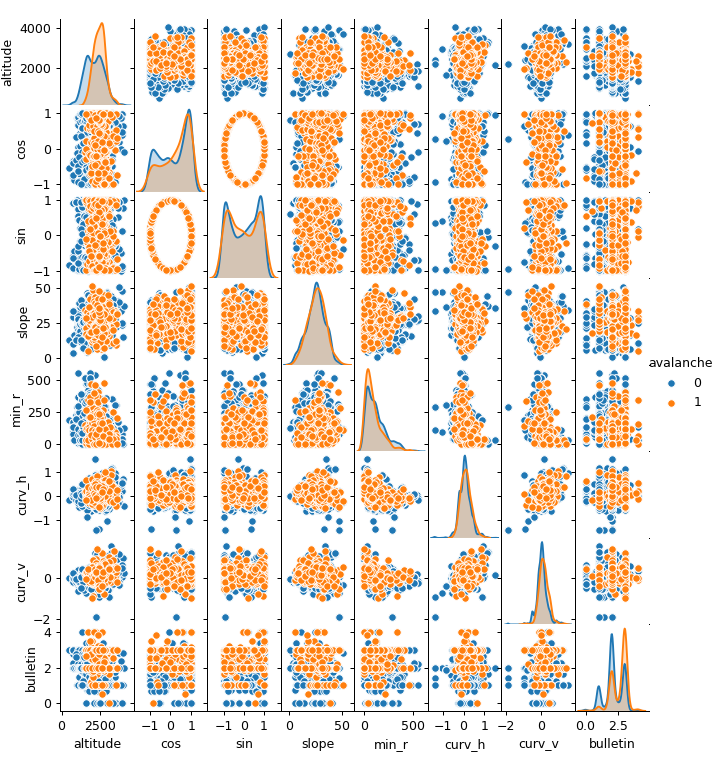

C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [13]:
%matplotlib notebook

df_all=pd.concat([df_tours_final,df_accidents_final])
df_all['cos']=df_all['expo'].apply(lambda x: np.cos(x))
df_all['sin']=df_all['expo'].apply(lambda x: np.sin(x))
df_all.drop(labels='expo',axis=1,inplace=True)

column_sequence_final = ['altitude','cos','sin','slope','min_r','curv_h','curv_v','bulletin','avalanche']
df_all = df_all.reindex(columns=column_sequence_final)

# pretty_print(df_all.head())
# pretty_print(df_all.tail())


sns.pairplot(df_all,hue='avalanche',height=1,vars=[x for x in column_sequence_final if x != 'avalanche'])
plt.subplots_adjust(wspace=0, hspace=0)

# print('Bivariate correlation coefficients:')
# corr=df_all.corr()
# corr.style.background_gradient(cmap='coolwarm', axis=None)

- visualization predictor distribtution for avalanche (orange) and no-avalanche(blue) classes

# 6. Learning models

### - SCORING
__Requirements for a tentative score/measure for predictor performance:__
- want to __avoid false negatives (FN) at all cost__ (accident when none was predicted) 
    - low FN compared to all accidents = (true positives TP + FN) 
    - denoted FALSE-NEGATIVE-RATE (FNR)
    - low FNR = FN/(FN+TP) = 1 - TPR
    
    
- want to __avoid too much false positives (FP)__ (a condition is predicted to be dangerous when it is not)
    - high TN compared to all non-accidents = (TN + false positives FP) 
    - denoted TRUE-NEGATIVE-RATE (TNR)
    - high TNR = TN/(TN+FP) = 1- FPR
    
    
- __FNR and TNR are used to asses the estimator__
- sketch below shows sklearn orientation for cunfusion matrices

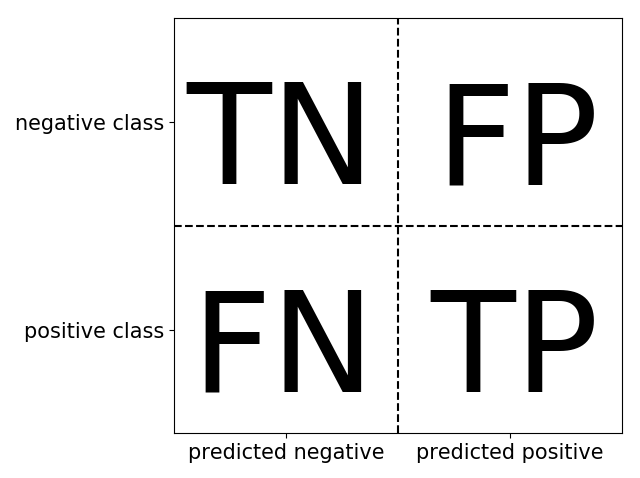

### - define the FNR, TNR scorer functions

In [14]:
def FNR_score(y_test,y_predict):
    return 1-recall_score(y_test,y_predict)

def TNR_score(y_test,y_predict):
    conf=confusion_matrix(y_test,y_predict)
    return conf[0][0]/(conf[0][0]+conf[0][1])

### - import statistics librariers

In [15]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, make_scorer, accuracy_score, recall_score, precision_score, log_loss, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
import mglearn
from lib_ML import IdentityTransformer as IT
from lib_ML import nested_GSCV


### - create a basic split into train and test data

In [16]:
random_state_split=7
X = df_all[[x for x in column_sequence_final if x != 'avalanche']]
y = df_all['avalanche']
X_train, X_test, y_train , y_test = train_test_split(X,y,stratify=y,random_state=random_state_split,test_size=0.35,shuffle=True)
print('Training samples: {}'.format(X_train.shape))
print('Test samples: {}'.format(X_test.shape))
print('Counts in training:\n{}'.format(y_train.value_counts()))
print('Counts in test:\n{}'.format(y_test.value_counts()))

Training samples: (1973, 8)
Test samples: (1063, 8)
Counts in training:
0    1700
1     273
Name: avalanche, dtype: int64
Counts in test:
0    916
1    147
Name: avalanche, dtype: int64


- all observations imported above where shuffled and split into a training set of ~2000 samples and a test set of ~ 1000 samples.
- in the following, the training set is used to train an algorithm and the performance is assessed by calculating TNR and FNR score of the trained algorithm on the untouched test set
- to achieve "final" performance scores somewhat more elaborate cross-validation schemes are necessary, but for a coarse comparison this should be sufficient

## 6.0 Dummy classification
- A classifier that randomly assigns predictions to be true with a probability given by the share of positive samples in the dataset

In [18]:
print('\nStratified dummy:')
dummy=DummyClassifier(strategy='stratified')
dummy.fit(X_train,y_train)
confusion = confusion_matrix(y_test,dummy.predict(X_test))
score=1-recall_score(y_test,dummy.predict(X_test))
print(confusion)
print('FNR: {:.2f}'.format(FNR_score(y_test,dummy.predict(X_test))))
print('TNR: {:.2f}'.format(FNR_score(y_test,dummy.predict(X_test))))


Stratified dummy:
[[790 126]
 [124  23]]
FNR: 0.88
TNR: 0.88


- So without further knowledge about the bulletin/terrain, only knowing how much accidents there are in the dataset, one would have an FNR of nearly 90%, and reject about 10% of actually save tours. This serves as tentative baseline for the methods introduced below.

## 6.1 Logistic classification
- A linear parametrization of the class posterior probability
- Set $$p(C=1\mid x)=\sigma(w^Tx+w_0)$$ with $\sigma$ the sigmoid function, $x$ the feature vector and $w$ parameters to be fitted to the data
- Maximize the likelihood $$min_w \prod_i \sigma(w^Tx_i+w_0)^{y_i}\cdot (1-\sigma(w^Tx_i+w_0))^{1-y_i}$$ with $x_i, y_i$ being the i-th observation of the in/dependent variable with respect to the model parameters $w$
- Having the max. likelihood parameters for $w$ predictions for a new, unseen $x_{N+1}$ can be made i.e. the sample is assigned to the class with the larger posterior probability $p(C\mid x_{N+1})$ 

In [20]:
# numerical solver parameters
solver = 'lbfgs'
penalty = 'l2'
max_iter = 1e4
tol = 1e-6
random_state=42
num_string='rnd_splt: '+str(random_state_split)+', '+'rnd_num: '+str(random_state)+', '+\
           'tol: '+str(tol)+', '+'max_iter: '+str(max_iter)+', '+\
           'penalty: '+str(penalty)+', '+'solver: '+str(solver)


<IPython.core.display.Javascript object>


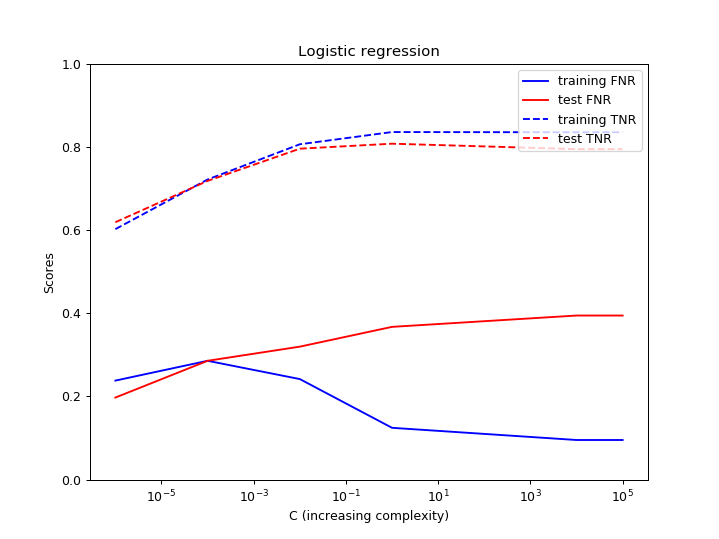

FNR at C=1: 0.37
Confusion matrix at C=1:
[[740 176]
 [ 54  93]]


In [26]:
%matplotlib notebook
training_fnr = []
test_fnr = []
training_tnr = []
test_tnr = []
test_confusion = []
parameters = [1e-6,1e-4,1e-2,1,1e4,1e4,1e5]

for p in parameters:
    # build the model
    logit=LogisticRegression(solver='lbfgs',penalty=penalty,C=p,random_state=random_state,max_iter=max_iter,tol=tol,n_jobs=-1,
                            fit_intercept=True,class_weight='balanced')
    poly=PolynomialFeatures(degree=3,interaction_only=False,include_bias=False)
    pipe = make_pipeline(RobustScaler(),poly,IT(),logit) 
    
    pipe.fit(X_train, y_train)
    training_fnr.append(FNR_score(y_train,pipe.predict(X_train)))
    test_fnr.append(FNR_score(y_test,pipe.predict(X_test)))
    
    training_tnr.append(TNR_score(y_train,pipe.predict(X_train)))
    test_tnr.append(TNR_score(y_test,pipe.predict(X_test)))
    
    test_confusion.append(confusion_matrix(y_test,pipe.predict(X_test)))
min_idx  = np.argmin(test_fnr)  
fig,ax=plt.subplots(figsize=(8,6))
plt.semilogx(parameters, training_fnr, label="training FNR",linestyle='-',c='b')
plt.semilogx(parameters, test_fnr, label="test FNR",linestyle='-',c='r')
plt.semilogx(parameters, training_tnr, label="training TNR",linestyle='--',c='b')
plt.semilogx(parameters, test_tnr, label="test TNR",linestyle='--',c='r')
plt.ylabel("Scores")
plt.ylim(0,1)
plt.title('Logistic regression')
plt.xlabel("C (increasing complexity)")
plt.legend(loc='upper right')
text=''.join([str(key)+': '+value.get_params().__str__().replace(', ','\n')+' \n' for key, value in pipe.named_steps.items()])

# plt.gca().text(0.1, 0.5, text, horizontalalignment='left',verticalalignment='center',fontsize=8, transform=ax.transAxes)
# plt.gca().text(0.1, 0.1, num_string, horizontalalignment='left',verticalalignment='center',fontsize=8, transform=ax.transAxes)

print('FNR at C=1: {:.2f}'.format(test_fnr[3]))
print('Confusion matrix at C=1:\n{}'.format(test_confusion[3]))

- __Reading this graph:__
- The x-axis is a model parameter that has to be optimized (complexity of the model)
- The y-axis shows the model scores TNR (dashed) and FRN (solid) as introduced above for training (blue) and test data (red)
- the __performance on the test data (red)__ is of most relevance (as the model will overperform on the data it has learned)

### - typical results
A typical result: __Based on the terrain attributes and the daily bulletin only__ the model (C=1) yields:
- A confusion matrix that shows that 
    - 740 samples were assigned correctly to be "no-avalanches"
    - 93 samples were assigned correctly to be "avalanches"
    - 176 samples were misassigned to be avalanches where actually they were not
    - 54 samples were misassigned to be no-avalanches while they acutally where avalanches
- This results in:
    - a TNR of ~80%, meaning that around __20% of acutally "save" conditions are rejected__
    - a FNR of ~30-40%, meaning that about __60% of avalanches could be predicted__


Some technical details:
- polynomial interaction of the features (slope, bulletin, altitude...) is important
    - linear combinations of the primary features scores significantly worse
- a range of feature preprocessing and complexity penalty yield similar results 
    - polynomial degree: 3,4
    - complexity penalty: 0.1 - 1000
    - scaler: StandardScaler, MinMaxScaler, PowerTransform

### - run a cross-validation over different splits of the training/test data (not shown)

In [112]:
# logit=LogisticRegression(solver=solver,penalty=penalty,C=1e-2,random_state=random_state,max_iter=max_iter,class_weight='balanced',tol=tol,n_jobs=-1)
# poly=PolynomialFeatures(degree=3,interaction_only=False,include_bias=False)
# pipe = make_pipeline(RobustScaler(),poly,IT(),logit)
# pipe.named_steps

# param_grid = {'logisticregression__C':[1e-4,1e-2,1,1e4,1e4,1e5]}
# splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
# print('FNR SCORES:\n')
# nested_GSCV(pipe,param_grid=param_grid,X=X.values,y=y.values,metric=FNR_score,outer_splitter=splitter,inner_splitter=splitter,add_CV=True)
# print('TNR SCORES:\n')
# nested_GSCV(pipe,param_grid=param_grid,X=X.values,y=y.values,metric=TNR_score,outer_splitter=splitter,inner_splitter=splitter,add_CV=True)


- the results are within 5-10% for different splits of the training/test data, apparently rather robust models

### - variation of acceptance treshold
- by default, a class is assigned when the associated probability for a samples is > 0.5
- this value (threshold) can be tuned and the misclassification scores plotted as function of the threshold probability
- as can be seen in the next plot - for the logistic model with C=1 - the TNR drops together with the FNR
     - __could make model more conservative by reducing the threshold, but it is found that this would continously also increases misclassification of "safe" conditions__

<IPython.core.display.Javascript object>


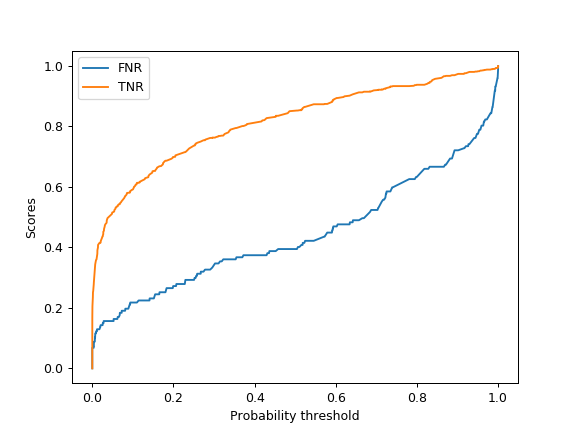

In [22]:
logit=LogisticRegression(solver='lbfgs',penalty=penalty,C=1,random_state=random_state,max_iter=max_iter,tol=tol,n_jobs=-1,
                            fit_intercept=True,class_weight='balanced')
poly=PolynomialFeatures(degree=4,interaction_only=False,include_bias=False)
pipe = make_pipeline(RobustScaler(),poly,IT(),logit) 
pipe.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test,pipe.predict_proba(X_test)[:,1])
thresholds[0]=thresholds[0]-1
fig,ax=plt.subplots()
# ax.plot(thresholds,fpr,label='fpr')
ax.plot(thresholds,1-tpr,label='FNR')
ax.plot(thresholds,1-fpr,label='TNR')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Scores')
ax.legend();

## 6.2 Support vector machines
- a description of this discriminative classifier can be found in "Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006"

In [24]:
# numerical solver parameters
solver = 'lbfgs'
penalty = 'l2'
max_iter = 1e7
tol = 1e-4
random_state=42

<IPython.core.display.Javascript object>


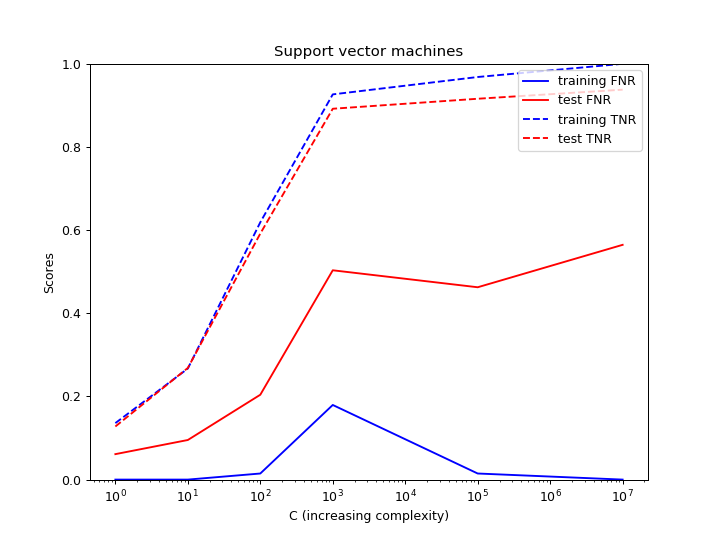

FNR at C=1e5: 0.46
Confusion matrix at C=1e5:
[[839  77]
 [ 68  79]]


In [28]:
%matplotlib notebook
training_fnr = []
test_fnr = []
training_tnr = []
test_tnr = []
test_confusion = []
parameters = [1,10,1e2,1e3,1e5,1e7]

for p in parameters:
    # build the model
    svc=SVC(C=p,kernel='poly',degree=3,gamma='scale',probability=False,random_state=random_state,max_iter=max_iter,tol=tol,class_weight='balanced')
    poly=PolynomialFeatures(degree=3,interaction_only=False,include_bias=True)
    pipe = make_pipeline(RobustScaler(),poly,IT(),svc) 
    
    pipe.fit(X_train, y_train)
    training_fnr.append(FNR_score(y_train,pipe.predict(X_train)))
    test_fnr.append(FNR_score(y_test,pipe.predict(X_test)))
    
    training_tnr.append(TNR_score(y_train,pipe.predict(X_train)))
    test_tnr.append(TNR_score(y_test,pipe.predict(X_test)))
    
    test_confusion.append(confusion_matrix(y_test,pipe.predict(X_test)))
min_idx  = np.argmin(test_fnr)  
fig,ax=plt.subplots(figsize=(8,6))
plt.semilogx(parameters, training_fnr, label="training FNR",linestyle='-',c='b')
plt.semilogx(parameters, test_fnr, label="test FNR",linestyle='-',c='r')
plt.semilogx(parameters, training_tnr, label="training TNR",linestyle='--',c='b')
plt.semilogx(parameters, test_tnr, label="test TNR",linestyle='--',c='r')
plt.ylabel("Scores")
plt.ylim(0,1)
plt.title('Support vector machines')
plt.xlabel("C (increasing complexity)")
plt.legend(loc='upper right')
text=''.join([str(key)+': '+value.get_params().__str__().replace(', ','\n')+' \n' for key, value in pipe.named_steps.items()])

# plt.gca().text(0.1, 0.5, text, horizontalalignment='left',verticalalignment='center',fontsize=8, transform=ax.transAxes)
# plt.gca().text(0.1, 0.1, num_string, horizontalalignment='left',verticalalignment='center',fontsize=8, transform=ax.transAxes)

print('FNR at C=1e5: {:.2f}'.format(test_fnr[4]))
print('Confusion matrix at C=1e5:\n{}'.format(test_confusion[4]))


### - typical results
- overall, not strikingly different results compared to the logistic regression
- possibly somewhat higher TNR possible
- no systematic comparison of feature scaling and kernel parameters was done yet

## 6.3 Nearest neighbors

<IPython.core.display.Javascript object>


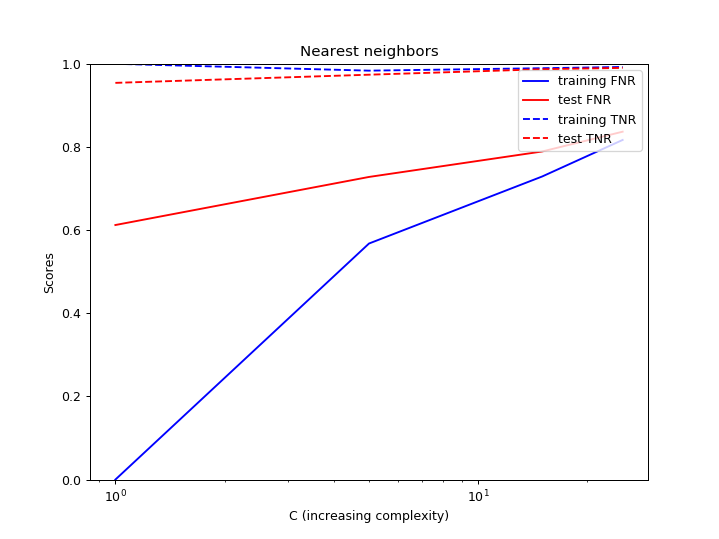

FNR at 1 nearest neighbor: 0.61
Confusion matrix at 1 nearest neighbor:
[[874  42]
 [ 90  57]]


In [31]:
%matplotlib notebook
training_fnr = []
test_fnr = []
training_tnr = []
test_tnr = []
test_confusion = []
parameters = [1,5,15,25]

for p in parameters:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=p)
    poly=PolynomialFeatures(degree=3,interaction_only=False,include_bias=False)
    pipe = make_pipeline(StandardScaler(),IT(),IT(),knn) 
    
    pipe.fit(X_train, y_train)
    training_fnr.append(FNR_score(y_train,pipe.predict(X_train)))
    test_fnr.append(FNR_score(y_test,pipe.predict(X_test)))
    
    training_tnr.append(TNR_score(y_train,pipe.predict(X_train)))
    test_tnr.append(TNR_score(y_test,pipe.predict(X_test)))
    
    test_confusion.append(confusion_matrix(y_test,pipe.predict(X_test)))
min_idx  = np.argmin(test_fnr)  
fig,ax=plt.subplots(figsize=(8,6))
plt.semilogx(parameters, training_fnr, label="training FNR",linestyle='-',c='b')
plt.semilogx(parameters, test_fnr, label="test FNR",linestyle='-',c='r')
plt.semilogx(parameters, training_tnr, label="training TNR",linestyle='--',c='b')
plt.semilogx(parameters, test_tnr, label="test TNR",linestyle='--',c='r')
plt.ylabel("Scores")
plt.ylim(0,1)
plt.title('Nearest neighbors')
plt.xlabel("C (increasing complexity)")
plt.legend(loc='upper right')
text=''.join([str(key)+': '+value.get_params().__str__().replace(', ','\n')+' \n' for key, value in pipe.named_steps.items()])

# plt.gca().text(0.1, 0.5, text, horizontalalignment='left',verticalalignment='center',fontsize=8, transform=ax.transAxes)
# plt.gca().text(0.1, 0.1, num_string, horizontalalignment='left',verticalalignment='center',fontsize=8, transform=ax.transAxes)

print('FNR at 1 nearest neighbor: {:.2f}'.format(test_fnr[0]))
print('Confusion matrix at 1 nearest neighbor:\n{}'.format(test_confusion[0]))



### - typical results
- with a high FNR around 60% the results appear inferior compared to the above classifiers
- however, no systematic comparison of feature scaling and kernel parameters was done yet

# 7. Conclusion
- __With quite little data input and rudimentary statistical modeling, already 60-70% of "avalanche" conditions can be identified, while only around 20% of "no-avalanche" conditions are misclassified.__

- Next steps could include:
    - include higher resolution meteorological data
    
    - implementing/study of "expert features"
        - interaction of closest ridge- and wind-directions could be modeled as an additional feature (some resonance like term) that goes high when a ridge is close AND wind came from that direction AND there was some percipitation in a given timewindow before
        - influence of temperature; add a feature that quantifies/and allows to include effects such as a first increase in temperature after percipitation (~bad) or a period of temperatures >0°C (~good)
        - or try to detect such effects in additional learning stages
             
    - possibly include features from SNOWPACK simulations
    
    - improve consistency of samples 
        - more information about individual avalanches (probably more info about release available)
        - more elaborate selection of tours, which points on tracks should be selected for statistically sound conclusions?
        
    - compare to different levels of backcountry-experience i.e. assessement of experts and establish suitable baseline scores      
    - determine strategy to deal with sample imbalance (the probability for reporting accidents vs. tours) and appropriate sampling strategies
    - find other and improve statistical modeling
    - explore if/how the statistically derived rules can be understood/simplified and implemented in the field
    
    
__Personal comment__:
_Evidently, given a limited amount of time and the non-availability of more informative meteorological timeseries, this document only represents a first approximation of the issue. This report emerged from a self-study on machine learning and related statistics since I finished my PhD. The idea for this approach arose during a skitour in Val Bedretto with my father._


## Appendix (please ignore)
### Code snippets

In [77]:
# print('Intercept: {}'.format(pipe.named_steps['logisticregression'].intercept_[0]))
# fig,ax=plt.subplots()
# coefs_ = pipe.named_steps['logisticregression'].coef_.reshape(-1,1)
# ax.plot(coefs_)
# ax.set_xticks(np.arange(len(coefs_)))

# # pipe.named_steps['polynomialfeatures'].get_feature_names(X_test.columns)
# coefs_idx=pipe.named_steps['polynomialfeatures'].get_feature_names(X_test.columns)
# coefs_=pipe.named_steps['logisticregression'].coef_.reshape(-1,1)
# df_coefs=pd.DataFrame(coefs_,index=coefs_idx)
# pretty_print(df_coefs.sort_values(by=0).head(10))
# (df_coefs.sort_values(by=0).tail(10))
# # df_coefs.plot(kind='bar')

### Export commands

In [42]:
import os
!jupyter nbconvert --to html learning_from_bulletins.ipynb

[NbConvertApp] Converting notebook learning_from_bulletins.ipynb to html
[NbConvertApp] Writing 1273232 bytes to learning_from_bulletins.html


In [37]:
!jupyter nbconvert learning_from_bulletins.ipynb --to slides --SlidesExporter.reveal_theme=serif --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_transition=none

[NbConvertApp] Converting notebook learning_from_bulletins.ipynb to slides
[NbConvertApp] Writing 1278526 bytes to learning_from_bulletins.slides.html
